In [39]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("dataSet").getOrCreate()
file = "heart_2020_cleaned.csv"
df = spark.read.csv(file, header=True, inferSchema=True)

columns_to_drop = ["Race", "MentalHealth", "PhysicalHealth"]
df = df.drop(*columns_to_drop)

from pyspark.sql.functions import stddev, mean, abs, col
bmi_stats = df.select(mean(col("BMI")).alias("mean_BMI"), stddev(col("BMI")).alias("stddev_BMI")).first()
mean_bmi = bmi_stats["mean_BMI"]
stddev_bmi = bmi_stats["stddev_BMI"]
sleep_time_stats = df.select(mean(col("SleepTime")).alias("mean_SleepTime"), stddev(col("SleepTime")).alias("stddev_SleepTime")).first()
mean_sleep_time = sleep_time_stats["mean_SleepTime"]
stddev_sleep_time = sleep_time_stats["stddev_SleepTime"]
threshold = 3
df = df.withColumn("z_score_BMI", abs((col("BMI") - mean_bmi) / stddev_bmi))
df = df.withColumn("z_score_SleepTime", abs((col("SleepTime") - mean_sleep_time) / stddev_sleep_time))
df = df.filter(col("z_score_BMI") <= threshold)
df = df.filter(col("z_score_SleepTime") <= threshold)
df = df.drop("z_score_BMI", "z_score_SleepTime")

df = df.dropna()

from pyspark.sql import functions as F

df = df.withColumn(
    'BMI_Category',
    F.when((df['BMI'] < 18.5), 'Low')
    .when((df['BMI'] >= 18.5) & (df['BMI'] < 24.9), 'Normal')
    .when((df['BMI'] >= 25.0) & (df['BMI'] < 29.9), 'Over')
    .when((df['BMI'] >= 30.0) & (df['BMI'] < 34.9), 'ObeseI')
    .when((df['BMI'] >= 35.0) & (df['BMI'] < 39.9), 'ObesityII')
    .otherwise('ObesityIII')
)
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

binary_features = ["HeartDisease", "AlcoholDrinking", "Stroke", "DiffWalking", "Smoking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

for column in binary_features:
    df = df.withColumn(column, F.when(df[column] == 'Yes', 1).otherwise(0))

df = df.withColumn("Sex", F.when(df["Sex"] == "Male", 1).otherwise(0))

df = df.withColumn("Diabetic", F.when(df["Diabetic"] == "No, borderline diabetes", 0).when(df["Diabetic"] == "Yes (during pregnancy)", 1).otherwise(df["Diabetic"]))


string_indexer = StringIndexer(inputCol="BMI_Category", outputCol="BMI_Category_Index")
model = string_indexer.fit(df)
df = model.transform(df)

string_indexer = StringIndexer(inputCol="AgeCategory", outputCol="AgeCategory_Index")
model = string_indexer.fit(df)
df = model.transform(df)

string_indexer = StringIndexer(inputCol="GenHealth", outputCol="GenHealth_Index")
model = string_indexer.fit(df)
df = model.transform(df)

columns_to_drop = ["BMI_Category", "AgeCategory", "GenHealth"]
df = df.drop(*columns_to_drop)

df.show()

+------------+-----+-------+---------------+------+-----------+---+--------+----------------+---------+------+-------------+----------+------------------+-----------------+---------------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|DiffWalking|Sex|Diabetic|PhysicalActivity|SleepTime|Asthma|KidneyDisease|SkinCancer|BMI_Category_Index|AgeCategory_Index|GenHealth_Index|
+------------+-----+-------+---------------+------+-----------+---+--------+----------------+---------+------+-------------+----------+------------------+-----------------+---------------+
|           0| 16.6|      1|              0|     0|          0|  0|       1|               1|        5|     1|            0|         1|               5.0|              3.0|            0.0|
|           0|20.34|      0|              0|     1|          0|  0|       0|               1|        7|     0|            0|         0|               1.0|              5.0|            0.0|
|           0|26.58|      1|              0|     0|    

In [41]:
import pandas as pd
pandas_df = df.toPandas()
from scipy.stats import chi2_contingency
alpha = 0.05

for column in pandas_df.columns:
    contingency_table = pd.crosstab(pandas_df['HeartDisease'], pandas_df[column])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    if p < alpha:
        print("Association between HeartDisease and", column, p)
    else:
        print("No significant association between HeartDisease and", column)


Association between HeartDisease and HeartDisease 0.0
Association between HeartDisease and BMI 7.180189531118136e-179
Association between HeartDisease and Smoking 0.0
Association between HeartDisease and AlcoholDrinking 2.0239494995520673e-74
Association between HeartDisease and Stroke 0.0
Association between HeartDisease and DiffWalking 0.0
Association between HeartDisease and Sex 0.0
Association between HeartDisease and Diabetic 0.0
Association between HeartDisease and PhysicalActivity 0.0
Association between HeartDisease and SleepTime 0.0
Association between HeartDisease and Asthma 2.634501629646072e-101
Association between HeartDisease and KidneyDisease 0.0
Association between HeartDisease and SkinCancer 0.0
Association between HeartDisease and BMI_Category_Index 2.3399707557015007e-194
Association between HeartDisease and AgeCategory_Index 0.0
Association between HeartDisease and GenHealth_Index 0.0


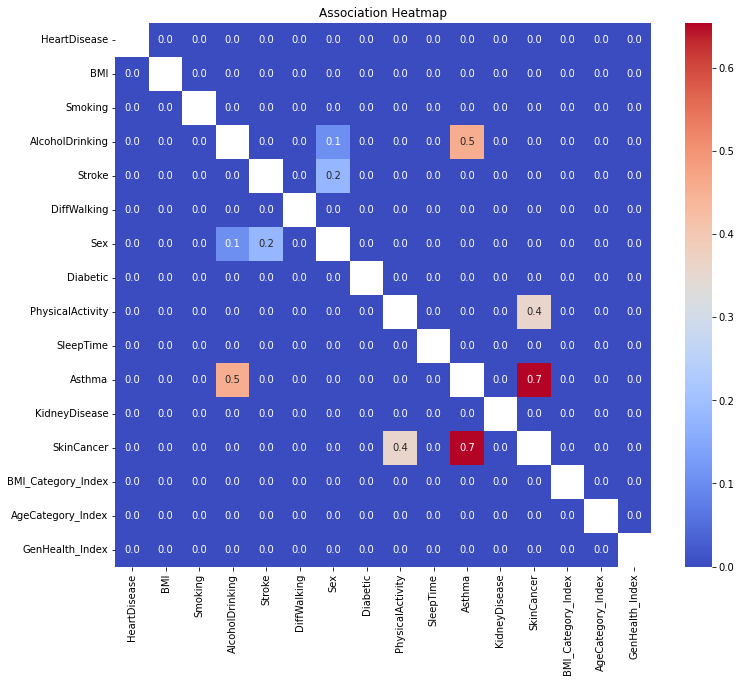

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

correlation_matrix = pd.DataFrame(columns=pandas_df.columns, index=pandas_df.columns)

for var1 in pandas_df.columns:
    for var2 in pandas_df.columns:
        if var1 != var2:  
            contingency_table = pd.crosstab(pandas_df[var1], pandas_df[var2])
            
            chi2, p, _, _ = chi2_contingency(contingency_table)
            
            correlation_matrix.at[var1, var2] = p  

correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Association Heatmap")
plt.show()


In [44]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

df_high = df.filter(df["HeartDisease"] == 0)
df_low = df.filter(df["HeartDisease"] == 1)

num_samples = df_low.count()

df_high_sampled = df_high.sample(False, num_samples / df_high.count(), seed=42)

df = df_high_sampled.union(df_low)

In [47]:
row_count = df.count()
print("Row Count:", row_count)


Row Count: 52328


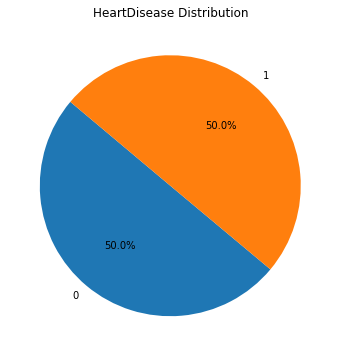

In [46]:
import matplotlib.pyplot as plt

heart_disease_counts = df.groupBy("HeartDisease").count().collect()

labels = [str(row["HeartDisease"]) for row in heart_disease_counts]
sizes = [row["count"] for row in heart_disease_counts]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("HeartDisease Distribution")
plt.show()
